In [24]:
import os
import torch
import torchvision
import numpy as np
import argparse
import pickle
import torch
import cv2
import glob
import random
import albumentations as A
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from PIL import Image

%matplotlib inline

# Cleaning labels

The code in this cell clears all other labels from the dataset so that only the label for the license plates remain.

In [172]:
input_dataset_path = "license-plates-yolo-data/"
output_dataset_path = "license-plates-yolo-data-clean/"

folders = ["train", "valid", "test"]
subs = ["images", "labels"]

for fold in folders:
    ds = os.path.join(input_dataset_path, fold)
    for label in glob.glob(os.path.join(ds, "labels/*")):
        with open(label, 'r') as f:
            clean_lines = []
            lines = f.readlines()
            for line in lines:
                class_id, x_min, y_min, x_max, y_max = line.rstrip().split(" ")
                if class_id == '0':
                    if line[-1] != '\n':
                        line += '\n'
                    clean_lines.append(line)
            f.close()            
        
        output_path = f"./{output_dataset_path}/{fold}/labels/{label.split('/')[-1]}"
        with open(output_path , 'a') as out:
            out.writelines(clean_lines)
            out.close()

# Dataset sample visualization

In [95]:
BOX_COLOR = (255, 0, 0) # Red
TEXT_COLOR = (255, 255, 255) # White

def visualize_bbox(img, bbox, class_name, color=BOX_COLOR, thickness=2):
    """Visualizes a single bounding box on the image"""
    x_center, y_center, width, height = bbox
    # x_min, x_max, y_min, y_max = int(x_min), int(x_min + w), int(y_min), int(y_min + h)
    # x_min, y_min, x_max, y_max = bbox
    
    # YOLO format - class_id x_center y_center width height
    x_min = int((float(x_center) - float(width)/2) * img.shape[1])
    y_min = int((float(y_center) - float(height)/2) * img.shape[0])
    x_max = int((float(x_center) + float(width)/2) * img.shape[1])
    y_max = int((float(y_center) + float(height)/2) * img.shape[0])

    cv2.rectangle(img, (int(x_min), int(y_min)), (int(x_max), int(y_max)), color=color, thickness=thickness)
    
    ((text_width, text_height), _) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1)    
    cv2.rectangle(img, (int(x_min), int(y_min) - int(1.3 * text_height)), (int(x_min) + text_width, int(y_min)), BOX_COLOR, -1)
    cv2.putText(
        img,
        text=class_name,
        org=(int(x_min), int(y_min) - int(0.3 * text_height)),
        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
        fontScale=0.35, 
        color=TEXT_COLOR, 
        lineType=cv2.LINE_AA,
    )
    return img


def visualize(image, bboxes_, category_ids, category_id_to_name):
    bboxes = bboxes_.copy()
    img = image.copy()
    for bbox in bboxes:
        category_id = int(bbox.pop(0))
        class_name = category_id_to_name[category_id]
        if category_id == 0:
            img = visualize_bbox(img, bbox, class_name)
    plt.figure(figsize=(12, 12))
    plt.axis('off')
    plt.imshow(img)

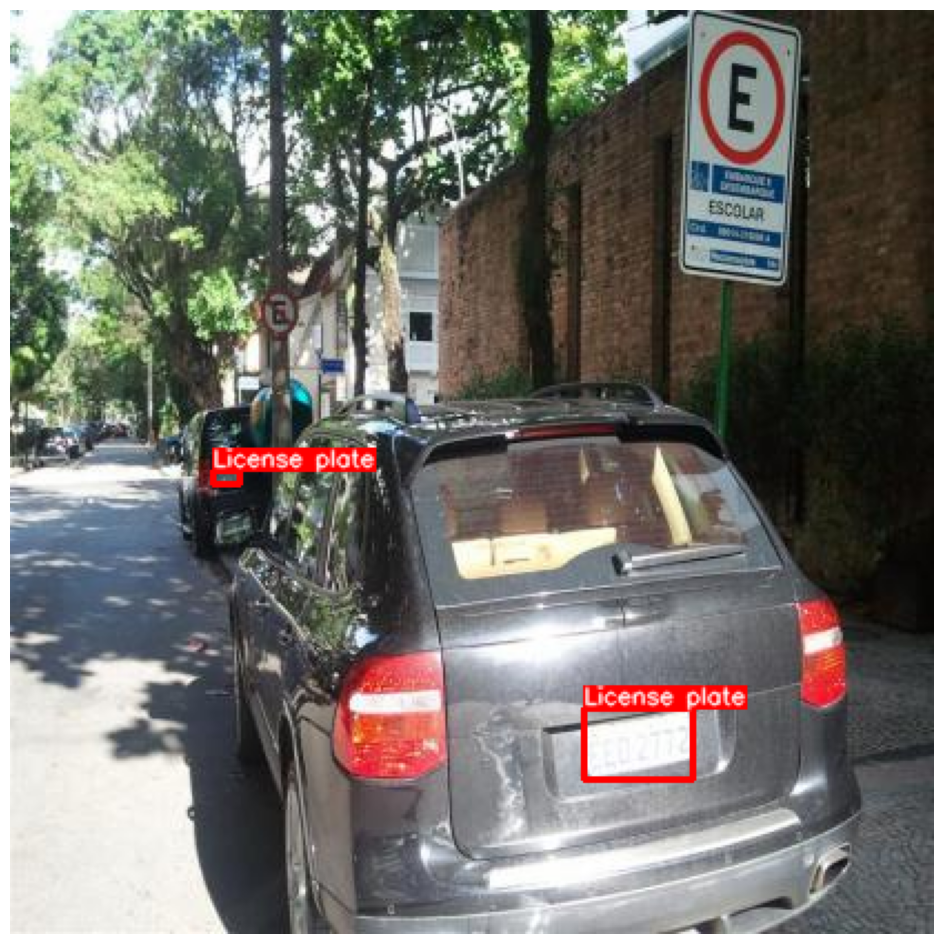

In [173]:
category_ids = [0]
category_id_to_name = {0: "License plate"}

file = "license-plates-yolo-data/train/labels/0c756c9366a8cb10_jpg.rf.5448d5081af4eddc034b35111e17a035.txt"
with open(file, 'r') as f:
    annotations = f.readlines()
    bboxes = []
    for line in annotations:
        label, x_min, y_min, x_max, y_max = line.rstrip().split(" ")
        # print(line.rstrip().split(" "))
        bboxes.append(line.rstrip().split(" "))
    
image = cv2.imread("license-plates-yolo-data/train/images/0c756c9366a8cb10_jpg.rf.5448d5081af4eddc034b35111e17a035.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
visualize(image, bboxes, category_ids, category_id_to_name)

# set IoU to be bigger during training

In [46]:
annotation_folder = os.path.join(dataset_path, "annotations")

category_ids = [0]
category_id_to_name = {0: "License plate"}

image = cv2.imread(os.path.join(dataset_path, "images/Cars0.png"))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# bboxes = [[5.66, 138.95, 147.09, 164.88], [366.7, 80.84, 132.8, 181.84]]
# for line in annotation_x.txt get bboxes
# Read annotation
annotation_path = os.path.join(annotation_folder, "Cars0.txt")
with open(annotation_path, 'r') as f:
    annotation = f.read().split(',')
    image_name, x_min, y_min, x_max, y_max, class_label = annotation
    annotation = [int(x_min), int(y_min), int(x_max), int(y_max)]
    print(annotation)

bboxes = [annotation]

transform = A.Compose([
    # A.HorizontalFlip(p=1.0),
     #A.RandomRain(p=1.0),
    A.Resize(height=1000, width=1000, always_apply=True),
    A.Equalize(p=1.0),
    # A.Normalize(p=1.0)
    A.Rotate(limit=20, p=1.0),# border_mode=cv2.BORDER_CONSTANT),
    A.OneOf([
        A.Blur(blur_limit=3, p=0.5),
        A.ColorJitter(p=0.5)
    ], p=1.0),
    A.PadIfNeeded(min_height=1500, min_width=1500, border_mode=0)
    ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['category_ids']),
)

visualize(image, bboxes, category_ids, category_id_to_name)
transformed = transform(image=image, bboxes=bboxes, category_ids=category_ids)
visualize(
    transformed['image'],
    transformed['bboxes'],
    transformed['category_ids'],
    category_id_to_name,
)

[ WARN:0@7625.847] global loadsave.cpp:244 findDecoder imread_('./license-plates-yolo-data/images/Cars0.png'): can't open/read file: check file path/integrity


error: OpenCV(4.7.0) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


In [9]:
# Loading the pretrained model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

In [42]:
# Converting annotations from xml to txt
annotations_folder = "/home/filipbootic/Downloads/archive/annotations"

for xml_file in os.listdir(annotations_folder):
    with open(os.path.join(annotations_folder, xml_file), 'r') as f:
        soup = BeautifulSoup(f, 'xml')
        filename = soup.find('filename').text
        xmin = int(soup.find('xmin').text)
        ymin = int(soup.find('ymin').text)
        xmax = int(soup.find('xmax').text)
        ymax = int(soup.find('ymax').text)
        with open(os.path.join(annotations_folder, xml_file.replace('.xml', '.txt')), 'w') as f:
            f.write(f"{filename}, {xmin}, {ymin}, {xmax}, {ymax}, license_plate")

In [261]:
# dataset_path = "/home/filipbootic/Downloads/archive/"
dataset_path = "/home/filipbootic/Documents/alpr/yolo-data"
category_ids = [0]
category_id_to_name = {0: "License plate"}

class LicensePlates(torch.utils.data.Dataset):
    def __init__(self, image_folder, annotation_folder, transforms):
        self.image_folder = image_folder
        self.annotation_folder = annotation_folder
        self.image_filenames = [f for f in os.listdir(image_folder) if f.endswith('.jpg')]
        self.to_tensor = torchvision.transforms.ToTensor()
        # self.to_grayscale = torchvision.transforms.Grayscale()
        # self.resize(800, 800)
        """self.augmentation = A.Compose([
            # A.RandomFlip(),
            A.HorizontalFlip(p=0.5),
            A.RandomRotate90(),
            A.PadIfNeeded(min_height=800, min_width=800, border_mode=0),
            A.ToGray()],
            bbox_params=A.BboxParams(format='coco', label_fields=['category_ids'])
        )"""
        self.augmentation = transforms
        # self.annotation_filenames = [f for f in os.listdir(image_folder) if f.endswith('.txt')]
        
    def __getitem__(self, index):
        
        image_path = os.path.join(self.image_folder, self.image_filenames[index])
        image = Image.open(image_path).convert("RGB")
        # image = self.to_grayscale(image)
        image = self.to_tensor(image)
        
        # Read annotation
        annotation_path = os.path.join(self.annotation_folder, self.image_filenames[index].replace('.jpg', '.txt'))
        with open(annotation_path, 'r') as f:
            annotation = f.read().split(' ')
            print(annotation)
            class_label, x_min, y_min, x_max, y_max = annotation
            annotation = [int(x_min), int(y_min), int(x_max), int(y_max)]
            
        
        print(self.image_filenames[index])
        augmented = self.augmentation(image=np.array(image), bboxes=np.array([annotation]), category_ids=category_ids)
        image = augmented['image']
        annotation = augmented['bboxes'][0]
        
        # Convert the image and annotations back to PIL image and tensors
        image = self.to_tensor(Image.fromarray(image))
        annotation = torch.tensor(annotation)
        
        return image, annotation
            
    def __len__(self):
        return len(self.image_filenames)

In [262]:
# Data augmentations
transforms = A.Compose([
    # A.HorizontalFlip(p=1.0),
    A.ToGray(always_apply=True),
    A.PadIfNeeded(min_height=800, min_width=800, border_mode=0, always_apply=True),
    A.RandomRain(p=0.05),
    # A.Equalize(p=1),
    A.Rotate(limit=20, p=1.0),   # border_mode=cv2.BORDER_CONSTANT),
    A.OneOf([
        A.Blur(blur_limit=3, p=0.5),
        A.ColorJitter(p=0.5)
    ], p=1.0),
    ], bbox_params=A.BboxParams(format='yolo', label_fields=['category_ids']),
)

# Create an instance of the custom dataset
license_plates_dataset = LicensePlates(image_folder=os.path.join(dataset_path, "images"), annotation_folder=os.path.join(dataset_path, "annotations"), transforms=transforms)

# Create a data loader for the custom dataset
data_loader = torch.utils.data.DataLoader(license_plates_dataset, batch_size=8, shuffle=True, num_workers=4)

In [263]:
license_plates_dataset[0]

['0', '0.14783653846153846', '0.3473557692307692', '0.03365384615384615', '0.027644230769230768\n0', '0.3557692307692308', '0.7427884615384616', '0.13581730769230768', '0.10817307692307693\n1', '0.10096153846153846', '0.27524038461538464', '0.20192307692307693', '0.20673076923076922\n1', '0.23197115384615385', '0.29086538461538464', '0.29927884615384615', '0.203125\n1', '0.47836538461538464', '0.5012019230769231', '0.7439903846153846', '0.8161057692307693\n1', '0.21634615384615385', '0.19471153846153846', '0.16947115384615385', '0.05048076923076923']


ValueError: too many values to unpack (expected 5)

In [81]:
# Get a sample from the data loader
sample = next(iter(data_loader))

# Access the image and the annotations from the sample
img, annotations = sample[0], sample[1]

# Plot the image
plt.imshow(img)

# Plot the bounding boxes
for annotation in annotations:
    bbox = annotation
    plt.gca().add_patch(plt.Rectangle((bbox[0], bbox[1]), bbox[2]-bbox[0], bbox[3]-bbox[1],
                                    fill=False, edgecolor='r', linewidth=2))

# Show the plot
plt.show()

RuntimeError: Caught RuntimeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/filipbootic/.local/lib/python3.10/site-packages/torch/utils/data/_utils/worker.py", line 302, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/filipbootic/.local/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 61, in fetch
    return self.collate_fn(data)
  File "/home/filipbootic/.local/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py", line 265, in default_collate
    return collate(batch, collate_fn_map=default_collate_fn_map)
  File "/home/filipbootic/.local/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py", line 143, in collate
    return [collate(samples, collate_fn_map=collate_fn_map) for samples in transposed]  # Backwards compatibility.
  File "/home/filipbootic/.local/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py", line 143, in <listcomp>
    return [collate(samples, collate_fn_map=collate_fn_map) for samples in transposed]  # Backwards compatibility.
  File "/home/filipbootic/.local/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py", line 120, in collate
    return collate_fn_map[elem_type](batch, collate_fn_map=collate_fn_map)
  File "/home/filipbootic/.local/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py", line 163, in collate_tensor_fn
    return torch.stack(batch, 0, out=out)
RuntimeError: stack expects each tensor to be equal size, but got [1, 267, 400] at entry 0 and [1, 276, 320] at entry 1


In [198]:
"""
TODO: 
Transformation
Augmentations - SADRŽI ČAK RandomRadin i RandomFog, poigraj se s njima!
Visalization
Training loop
Testing loop
Define device to train
Try images with: 1) just resizing; 2) just padding
Train the model on both grayscale and RGB images.

Checkout different bbox formats (pascal_voc is not normalized)
NOTE: Pazi da radi s više tablica na slici kod inferencije!!!
"""

'\nTODO: \nTransformation\nAugmentations - SADRŽI ČAK RandomRadin i RandomFog, poigraj se s njima!\nVisalization\nTraining loop\nTesting loop\nDefine device to train\nTry images with: 1) just resizing; 2) just padding\nTrain the model on both grayscale and RGB images.\n\nCheckout different bbox formats (pascal_voc is not normalized)\nNOTE: Pazi da radi s više tablica na slici kod inferencije!!!\n'

[226, 125, 419, 173]


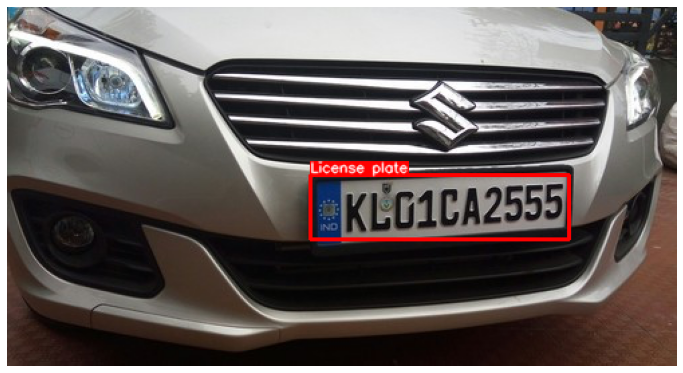

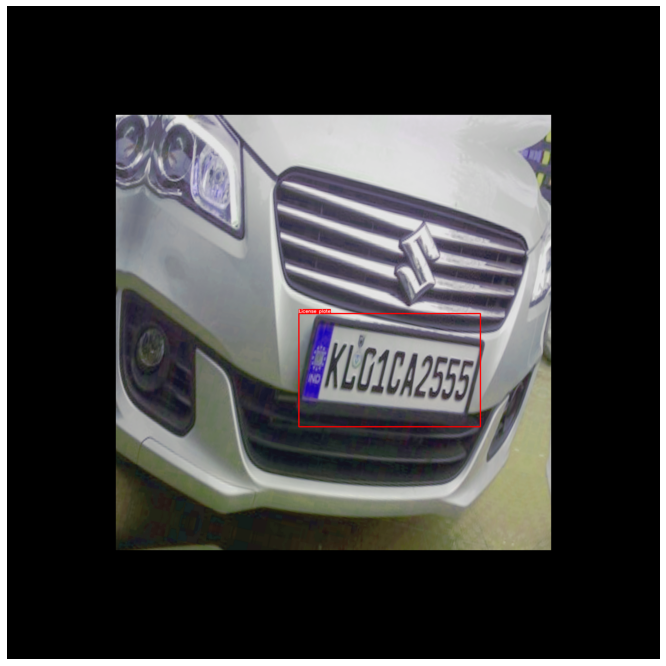

In [203]:
annotation_folder = os.path.join(dataset_path, "annotations")

category_ids = [0]
category_id_to_name = {0: "License plate"}

image = cv2.imread(os.path.join(dataset_path, "images/Cars0.png"))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# bboxes = [[5.66, 138.95, 147.09, 164.88], [366.7, 80.84, 132.8, 181.84]]
# for line in annotation_x.txt get bboxes
# Read annotation
annotation_path = os.path.join(annotation_folder, "Cars0.txt")
with open(annotation_path, 'r') as f:
    annotation = f.read().split(',')
    image_name, x_min, y_min, x_max, y_max, class_label = annotation
    annotation = [int(x_min), int(y_min), int(x_max), int(y_max)]
    print(annotation)

bboxes = [annotation]

transform = A.Compose([
    # A.HorizontalFlip(p=1.0),
     #A.RandomRain(p=1.0),
    A.Resize(height=1000, width=1000, always_apply=True),
    A.Equalize(p=1.0),
    # A.Normalize(p=1.0)
    A.Rotate(limit=20, p=1.0),# border_mode=cv2.BORDER_CONSTANT),
    A.OneOf([
        A.Blur(blur_limit=3, p=0.5),
        A.ColorJitter(p=0.5)
    ], p=1.0),
    A.PadIfNeeded(min_height=1500, min_width=1500, border_mode=0)
    ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['category_ids']),
)

visualize(image, bboxes, category_ids, category_id_to_name)
transformed = transform(image=image, bboxes=bboxes, category_ids=category_ids)
visualize(
    transformed['image'],
    transformed['bboxes'],
    transformed['category_ids'],
    category_id_to_name,
)

In [ ]:
# Create a grid of images with torchvision
images = ... # your images here
grid = utils.make_grid(images, nrow=5)
grid = grid.numpy().transpose((1, 2, 0))

# Create a figure and axes
fig, ax = plt.subplots()
ax.imshow(grid)

# Add bounding boxes to the images
bounding_boxes = ... # your bounding boxes here
for box in bounding_boxes:
    rect = Rectangle((box[0], box[1]), box[2], box[3], linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

# Show the plot
plt.show()